# Free-form injective flow with moons manifold

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from tqdm.auto import trange
from sklearn.datasets import make_moons

from ciflows.loss import volume_change_surrogate

import matplotlib.pyplot as plt

/Users/adam2392/miniforge3/envs/ciflows/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import torch
from torch.autograd import grad
from torch.autograd.forward_ad import dual_level, make_dual, unpack_dual
from collections import namedtuple
from math import sqrt, prod

SurrogateOutput = namedtuple(
    "SurrogateOutput", ["surrogate", "z", "x1", "regularizations"]
)


def sample_v(
    x: torch.Tensor, hutchinson_samples: int, manifold= None
) -> torch.Tensor:
    """
    Sample a random vector v of shape (*x.shape, hutchinson_samples)
    with scaled orthonormal columns.

    The reference data is used for shape, device and dtype.

    :param x: Reference data. Shape: (batch_size, ...).
    :param hutchinson_samples: Number of Hutchinson samples to draw.
    :param manifold: Optional manifold on which the data lies. If provided,
        the vectors are sampled in the tangent space of the manifold.
    :return: Random vectors of shape (batch_size, ...)
    """
    batch_size, total_dim = x.shape[0], prod(x.shape[1:])

    if hutchinson_samples > total_dim:
        raise ValueError(
            f"Too many Hutchinson samples: got {hutchinson_samples}, \
                expected <= {total_dim}"
        )
    # M-FFF: More than one Hutchinson sample not implemented for M-FFF
    if manifold is not None and hutchinson_samples != 1:
        raise NotImplementedError(
            f"More than one Hutchinson sample not implemented for M-FFF, \
                {hutchinson_samples} requested."
        )

    if manifold is None:
        v = torch.randn(
            batch_size, total_dim, hutchinson_samples, device=x.device, dtype=x.dtype
        )
        q = torch.linalg.qr(v).Q.reshape(*x.shape, hutchinson_samples)
        return q * sqrt(total_dim)
    # M-FFF: Sample v in the tangent space of the manifold at x
    # else:
    #     v = random_tangent_vec(manifold, x.detach(), n_samples=batch_size)
    #     v /= torch.norm(v, p=2, dim=list(range(1, len(v.shape))), keepdim=True)
    #     return v[..., None] * sqrt(total_dim)




def reconstruction_loss(
    a: torch.Tensor, b: torch.Tensor
) -> torch.Tensor:
    return torch.sum((a - b) ** 2, dim=tuple(range(1, len(a.shape))))


def sum_except_batch(x: torch.Tensor) -> torch.Tensor:
    """Sum over all dimensions except the first.
    :param x: Input tensor. Shape: (batch_size, ...)
    :return: Sum over all dimensions except the first. Shape: (batch_size,)
    """
    return torch.sum(x.reshape(x.shape[0], -1), dim=1)



def volume_change_surrogate_fff(
    x: torch.Tensor,
    encode,
    decode,
    hutchinson_samples: int = 1,
    manifold = None,
) -> SurrogateOutput:
    r"""Computes the surrogate for the volume change term in the change of
    variables formula. The surrogate is given by:
    $$
    v^T f_\theta'(x) \texttt{SG}(g_\phi'(z) v).
    $$
    The gradient of the surrogate is the gradient of the volume change term.

    :param x: Input data. Shape: (batch_size, ...)
    :param encode: Encoder function. Takes `x` as input and returns a latent
        representation `z` of shape (batch_size, latent_shape).
    :param decode: Decoder function. Takes a latent representation `z` as input
        and returns a reconstruction `x1`.
    :param hutchinson_samples: Number of Hutchinson samples to use for the
        volume change estimator. The number of hutchinson samples must be less
        than or equal to the total dimension of the data.
    :param manifold: Manifold on which the latent space lies. If provided, the
        volume change is computed in the tangent space of the manifold.
    :return: The computed surrogate of shape (batch_size,), latent representation
        `z`, reconstruction `x1` and regularization metrics computed on the fly.
    """
    regularizations = {}
    surrogate = 0

    x.requires_grad_()
    z = encode(x)

    # M-FFF: Project to manifold and store projection distance for
    # regularization
    if manifold is not None:
        z_projected = manifold.projection(z)
        regularizations["z_projection"] = reconstruction_loss(z, z_projected)
        z = z_projected

    vs = sample_v(z, hutchinson_samples, manifold)

    for k in range(hutchinson_samples):
        v = vs[..., k]

        # $ g'(z) v $ via forward-mode AD
        with dual_level():
            dual_z = make_dual(z, v)
            dual_x1 = decode(dual_z)

            # M-FFF: Project to manifold and store projection distance for
            # regularization
            if manifold is not None:
                dual_x1_projected = manifold.projection(dual_x1)
                regularizations["x1_projection"] = reconstruction_loss(
                    unpack_dual(dual_x1_projected)[0], unpack_dual(dual_x1)[0]
                )
                dual_x1 = dual_x1_projected

            x1, v1 = unpack_dual(dual_x1)

        # $ v^T f'(x) $ via backward-mode AD
        (v2,) = grad(z, x, v, create_graph=True)

        # $ v^T f'(x) stop_grad(g'(z)) v $
        surrogate += sum_except_batch(v2 * v1.detach()) / hutchinson_samples

    return SurrogateOutput(surrogate, z, x1, regularizations)


In [4]:
dim = 2
latent_dim = dim  # The code below also works for latent_dim < dim
hidden_dim = 128
n_steps = 10000

noise = 0.1

beta = 100
batch_size = 1024
device = "cpu"


class SkipConnection(torch.nn.Module):
    def __init__(self, inner):
        super().__init__()
        self.inner = inner

    def forward(self, x, *args, **kwargs):
        return x + self.inner(x, *args, **kwargs)


# Do not use ReLU below, makes training unstable
encoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, latent_dim)
).to(device))
decoder = SkipConnection(torch.nn.Sequential(
    torch.nn.Linear(latent_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, hidden_dim), torch.nn.SiLU(),
    torch.nn.Linear(hidden_dim, dim)
).to(device))

latent = torch.distributions.Independent(
    torch.distributions.Normal(
        loc=torch.zeros(latent_dim, device=device),
        scale=torch.ones(latent_dim, device=device),
    ),
    1
)

In [13]:

optim = torch.optim.Adam([*encoder.parameters(), *decoder.parameters()], lr=3e-4)

with trange(n_steps) as pbar:
    for step in pbar:
        optim.zero_grad()
        batch, _ = make_moons(batch_size, noise=noise)
        x = torch.from_numpy(batch).float().to(device)
        
        surrogate_loss, v, xhat = volume_change_surrogate(
            x, encoder, decoder, hutchinson_samples=1
        )
        loss_reconstruction = ((x - xhat) ** 2).sum(-1)
        loss_nll = -latent.log_prob(v) - surrogate_loss

        # surrogate = volume_change_surrogate_fff(
        #     x, encoder, decoder, hutchinson_samples=1
        # )
        # loss_reconstruction_fff = ((x - surrogate.x1) ** 2).sum(-1)#.mean(-1)
        # loss_nll_fff = -latent.log_prob(surrogate.z) - surrogate.surrogate

        # assert torch.allclose(loss_reconstruction, loss_reconstruction_fff)
        # # assert torch.allclose(surrogate_loss, surrogate.surrogate)
        # assert torch.allclose(loss_nll.mean(), loss_nll_fff.mean())

        loss = beta * loss_reconstruction + loss_nll
        loss.mean().backward()
        optim.step()

        if step % 100 == 0:
            pbar.set_description(f"Reconstruction: {loss_reconstruction.mean():.1e}, NLL: {loss_nll.mean():.2f}")
        #     with torch.no_grad():
        #         batch, _ = make_moons(batch_size, noise=noise)
        #         x = torch.from_numpy(batch).float().to(device)
        #         # surrogate_loss, v, xhat =  volume_change_surrogate(x, encoder, decoder, hutchinson_samples=1)
        #         # nll_out = -latent.log_prob(latent.sample((batch_size,))) - surrogate_loss
        #         # reconstruction = ((x - xhat) ** 2).sum(-1).mean(-1)

        #         surrogate = volume_change_surrogate(
        #             x, encoder, decoder, hutchinson_samples=1
        #         )
        #         loss_reconstruction = ((x - surrogate.x1) ** 2).sum(-1).mean(-1)
        #         loss_nll = -latent.log_prob(latent.sample((batch_size,))) - surrogate.surrogate
                
        #         pbar.set_description(f"Reconstruction: {loss_reconstruction:.1e}, NLL: {loss_nll.mean():.2f}")

Reconstruction: 2.3e-04, NLL: 0.88: 100%|██████████| 10000/10000 [02:37<00:00, 63.56it/s]


In [12]:
print(loss_nll.shape, loss_nll_fff.shape)
print(loss_nll.mean(), loss_nll_fff.mean())
# print(surrogate_loss, surrogate.surrogate)
print(surrogate_loss.mean(), surrogate.surrogate.mean())
print(loss_reconstruction.shape, loss_reconstruction_fff.shape)

torch.Size([1024]) torch.Size([1024])
tensor(0.5115, grad_fn=<MeanBackward0>) tensor(0.5115, grad_fn=<MeanBackward0>)
tensor(2.0000, grad_fn=<MeanBackward0>) tensor(2.0000, grad_fn=<MeanBackward0>)
torch.Size([1024]) torch.Size([1024])


In [14]:
def sample(n_samples):
    z = torch.randn(n_samples, latent_dim, device=device)
    return decoder(z)

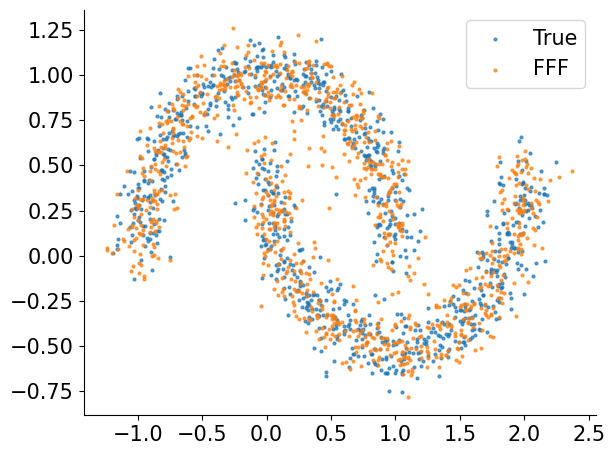

In [15]:
test_size = 1_000
test_batch, _ = make_moons(test_size, noise=noise)

plot_kwargs = dict(
    s=4,
    alpha=.7
)

plt.scatter(*test_batch.T, label="True", **plot_kwargs)

with torch.no_grad():
    plt.scatter(*sample(test_size).cpu().T, label="FFF", **plot_kwargs)
plt.legend()